# Modelling Lifetime Post Consumers

## Data Preparation

We first get the prepared dataset using functions in `preparation.py`. 

The data preprocessing procedure involves:
- Conversion of the columns `['Type', 'Category', 'Post Month', 'Post Weekday']` to categorical variables,
- Conversion of `hour` into `hour_x` and `hour_y` coordinates (optional),
- Filling the missing values (There is only one missing value in `Paid` column, which we fill by the most common value of the column - 0).
- Splitting the dataset into train and test sets, using a shuffle split, and a test size of 25%. We can test multiple train and test splits, using a larger `number_of_splits` param below, but we start with one split.
- Transformation of the columns `Page total likes` and `Lifetime Post Consumers` into a normal distribution using a quantile transformation. We do this to avoid training on skewed data, and better capture the extreme values.

## Building the model

We compare different regression algorithms to find which one fits the data better.

The algorithms tried are:

- Decision Tree Regressor
- Ridge (Linear Regression with L2 Regularisation)
- K-Neighbors Regressor
- Support Vector Regressor
- Random Forest Regressor
- XGBoost (eXtreme Gradient Boosting) Regressor

We do a randomised search for each algorithm to find the best hyperparameter set for each one of them, minimising the Mean Squared Error, and we compare the performance among all of them, returning the best model / hyperparameters.

The best fit is obtained by the XGBoost regressor. The next step is to optimise the model by applying Bayesian Optimization, using the parameters obtained in the random search, but also allowing for other randomly selected algorithms.

We evaluate the final model by measuring the Root Mean Squared Error score for both train and test sets, and displaying a grid with the predictions against the actual values. We also show the most important features for the XGBoost model.

Finally, we discuss future steps for improving the model and productionising the program.

## Imports

In [1]:
from preparation import *
from model import *

import matplotlib.pyplot as plt
import warnings

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

## Load Data and Configure Parameters

In [2]:
# First load the data
df = load_data()

number_of_splits = 1
seed = 42

# The following params are used for the random search cross-validation
n_iter = 80
k_fold = 3
n_jobs = 3
verbose = 1

# This parameter is set to True, so 
# `Page total likes` and `Lifetime Post Consumers`
# will be transformed using a PowerTransformer
do_transform = True

do_convert_hour = False
# The alternative is, using `do_convert_hour=True`, to transform hour
# into a coordinate system (hour_x, hour_y),
# to deal with the fact that 23:00 is close to 00:00

# However, as this doesn't improve the model
# we leave this conversion out for better clarity.

## Model Selection

In [3]:
%%time

for X_train, X_test, y_train_norm, y_test_norm, transformer_y in prepare_datasets(
        df,
        number_of_splits=number_of_splits,
        seed=seed,
        do_convert_hour=do_convert_hour,
        do_transform=do_transform
):

    selected_model, results_df = select_model(
        X_train, y_train_norm, regressors_list=REGRESSORS_LIST,
        k_fold=k_fold, n_iter=n_iter, n_jobs=n_jobs, verbose=verbose)
    
    selected_model.fit(X_train, y_train_norm)

    y_train_pred, y_test_pred, y_train, y_test = get_predictions(
        selected_model, X_train, y_train_norm, X_test, y_test_norm, 
        transformer_y=transformer_y)
    
    train_rmse, test_rmse = calc_rmse(y_train_pred, y_test_pred, y_train, y_test)

### Tuning DecisionTreeRegressor... ###
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


### Tuning Ridge... ###
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### Tuning KNeighborsRegressor... ###
Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=3)]: Done  42 out of  42 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


### Tuning SVR... ###
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done 235 out of 240 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:    4.9s finished


### Tuning RandomForestRegressor... ###
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   35.0s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:   43.3s finished


### Tuning XGBRegressor... ###
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   46.3s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:   54.9s finished



### Best model: XGBRegressor ###
Wall time: 1min 55s


We keep the last and only split of train and test set for the remaining of this model building. We could also try different splits, to evaluate the best option for each one of them, but for brevity of the results, we keep the one split.

Let's see now the selected model and compare the regressors:

In [4]:
print('The selected model is:\n')

print(selected_model)

print('\nWith scores:\nTrain RMSE = {:.01f}, Test RMSE = {:.01f}'.format(
    train_rmse, test_rmse))

The selected model is:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9999999999999999, gamma=2.7,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.37, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=450, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9999999999999999,
             tree_method=None, validate_parameters=False, verbosity=None)

With scores:
Train RMSE = 638.1, Test RMSE = 554.9


We will now see the results of the selection process between the regression algorithms in terms of the average test score, average prediction time and fit time.

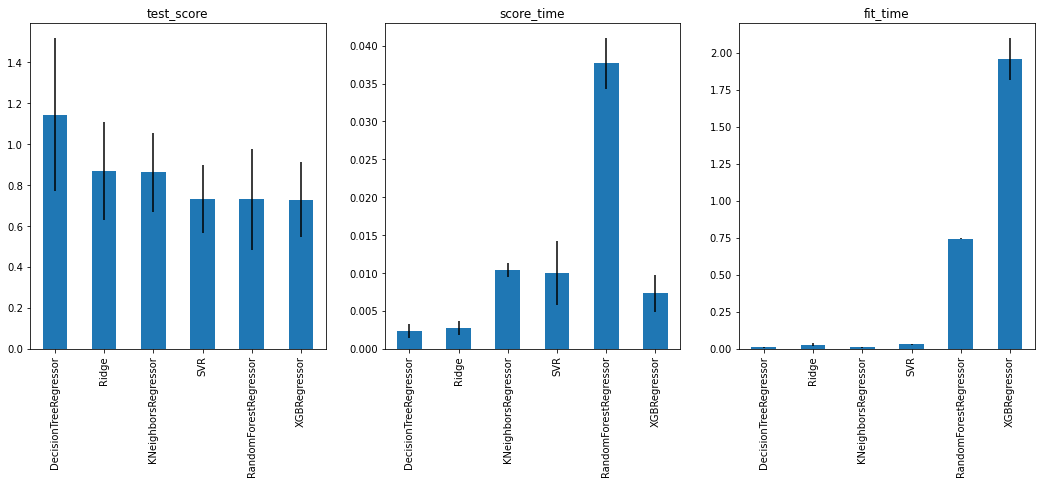

In [5]:
results_df.loc['mean_test_score'] = -results_df.loc['mean_test_score']
num = len(results_df.index)
fig, axes = plt.subplots(1, num // 2, figsize=(18, 6))
for i in range(0, num, 2):
    results_df.iloc[i, :].plot.bar(
        ax=axes[i // 2],
        yerr=results_df.iloc[i + 1, :] * 1.96
    )
    axes[i // 2].set_title(results_df.index[i][5:])

The three best fits are obtained by XGBoost, Random Forest and SVR. As discussed in model.py, the selection criterion is only the maximisation of the test score (negative rmse), without taking into consideration the fit and predict times. Depending on the criteria the application, this could also change, e.g. filtering out algorithms with high prediction times, in case this creates delays to a real-time application.

Note that the test_score here is the root mean squared error of the normalised y variable, and it is shown for comparison purposes.

## Bayesian Optimization

Let's try Bayesian Optimisation for XGBoost now. We will start using the parameters found in the random search before, while also searching for other 9 starting points. The number of iterations will be set to 100 for now.

In [6]:
init_points = 10
n_iter = 100

initial_search_point = {
    'max_depth': selected_model.max_depth,
    'learning_rate': selected_model.learning_rate,
    'n_estimators': selected_model.n_estimators,
    'gamma': selected_model.gamma,
    'subsample': selected_model.subsample,
    'colsample_bytree': selected_model.colsample_bytree,
}

# setting search bounds
xgb_search_bounds = {
    'max_depth': (3, 9),
    'learning_rate': (0.01, 1.0),
    'n_estimators': (10, 500),
    'gamma': (0, 5),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

In [7]:
def xgboost_regressor_hyper_param(max_depth, learning_rate, n_estimators,
                                  gamma, subsample, colsample_bytree):
    """ 
        This is the function to be maximised by the optimization
    """
    
    # Convert these parameters to integers
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    # create the model
    xgb = XGBRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    # Calcculate mean score
    mean_score = np.mean(
        cross_val_score(xgb, X_train, y_train_norm, cv=5,
                        scoring='neg_mean_squared_error'))
    return mean_score

# Create the optimization object
optimizer = BayesianOptimization(
    f=xgboost_regressor_hyper_param,
    pbounds=xgb_search_bounds,
    random_state=seed
)

# add the randomised search result as one of the initial search points 
optimizer.probe(
    params=initial_search_point,
    lazy=True,  # to evaluate these points only in the next `maximize`
)

In [8]:
%%time

# run the optimization
optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter
)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.7587   |  1.0      |  2.7      |  0.37     |  8.0      |  450.0    |  1.0      |
|  2        | -0.8821   |  0.6873   |  4.754    |  0.7347   |  6.592    |  86.45    |  0.578    |
|  3        | -0.7456   |  0.529    |  4.331    |  0.6051   |  7.248    |  20.09    |  0.985    |
|  4        | -0.7404   |  0.9162   |  1.062    |  0.19     |  4.1      |  159.1    |  0.7624   |
|  5        | -0.8502   |  0.716    |  1.456    |  0.6157   |  3.837    |  153.2    |  0.6832   |
|  6        | -0.7349   |  0.728    |  3.926    |  0.2077   |  6.085    |  300.3    |  0.5232   |
|  7        | -0.7758   |  0.8038   |  0.8526   |  0.0744   |  8.693    |  483.2    |  0.9042   |
|  8        | -1.113    |  0.6523   |  0.4884   |  0.6874   |  5.641    |  69.8     |  0.7476   |
|  9        | -0.736

Get the best parameters dictionary

In [9]:
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

print('The parameters that minimize mean squared error are:')
print(best_params)

The parameters that minimize mean squared error are:
{'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 452, 'subsample': 0.5}


We then train the final model based on the best parameters found by the Bayesian Optimization

In [10]:
%%time
model = XGBRegressor(**best_params)

model.fit(X_train, y_train_norm)

y_train_pred, y_test_pred, y_train, y_test = get_predictions(
    model, X_train, y_train_norm, X_test, y_test_norm,
    transformer_y=transformer_y)

train_rmse, test_rmse = calc_rmse(y_train_pred, y_test_pred, y_train, y_test)

Wall time: 622 ms


In [11]:
print('\nTrain RMSE = {:.01f}, Test RMSE = {:.01f}'.format(
    train_rmse, test_rmse))


Train RMSE = 693.6, Test RMSE = 532.9


We can also see the important features:

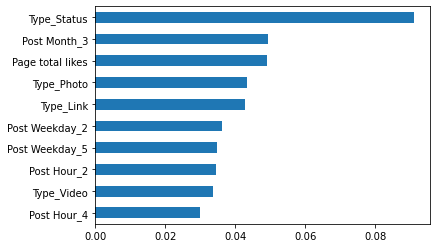

In [12]:
pd.Series(model.feature_importances_, 
          index=X_train.columns).sort_values().tail(10).plot.barh();

`Status` is the most important feature, with `Post Month_3` next, and `Page total likes` third.

Lets's now see the fit in a grid:

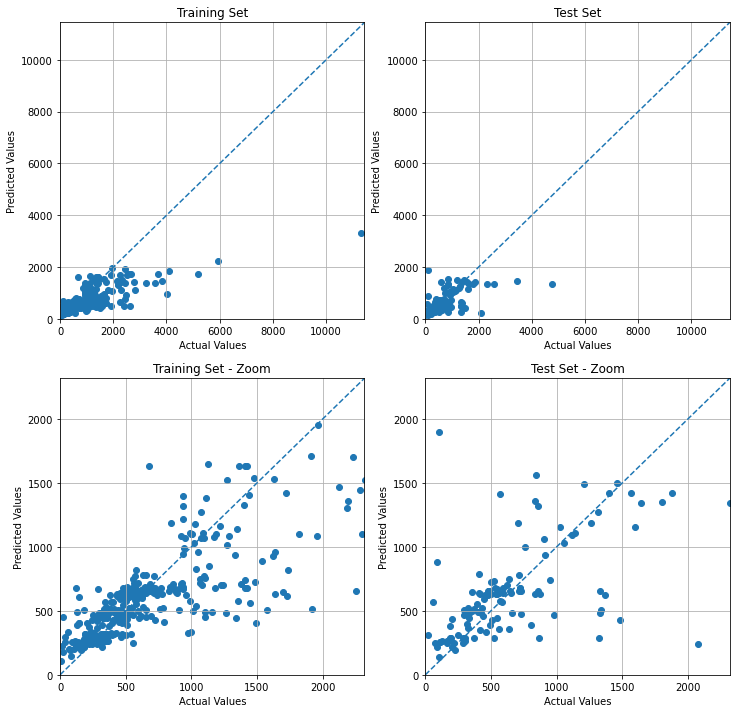

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].scatter(y_train, y_train_pred)
axes[0, 0].set_title('Training Set')
axes[1, 0].scatter(y_train, y_train_pred)
axes[1, 0].set_title('Training Set - Zoom')
axes[0, 1].scatter(y_test, y_test_pred)
axes[0, 1].set_title('Test Set')
axes[1, 1].scatter(y_test, y_test_pred)
axes[1, 1].set_title('Test Set - Zoom')

# Set the axis limits
# First we find the max value of y
y = np.concatenate([y_train, y_test])
# We use 101% of the max value for the top scatterplots
ymax = np.max(y) * 1.01
# And the 95th percentile for the zoomed scatterplots
yperc95 = np.percentile(y, 95)

axes[0, 0].set_xlim([0, ymax])
axes[0, 0].set_ylim([0, ymax])

axes[0, 1].set_xlim([0, ymax])
axes[0, 1].set_ylim([0, ymax])

axes[1, 0].set_xlim([0, yperc95])
axes[1, 0].set_ylim([0, yperc95])

axes[1, 1].set_xlim([0, yperc95])
axes[1, 1].set_ylim([0, yperc95])

for axx in axes:
    for ax in axx:
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')

        # draw the diagonal line to compare with the perfect fit
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--")
        
        ax.grid()

There is clearly some bias in the model, as the high values cannot be captured. We will now do the evaluation of the best model on multiple splits of the dataset.

### Evaluation in different splits

In [14]:
%%time
number_of_splits = 30
train_rmses = []
test_rmses = []
i = 0
for X_train, X_test, y_train_norm, y_test_norm, transformer_y in prepare_datasets(
        df, number_of_splits=number_of_splits,
        seed=seed,
        do_convert_hour=do_convert_hour,
        do_transform=do_transform
):
    i += 1
    print(f'### Split {i} ###')
    
    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train_norm)

    y_train_pred, y_test_pred, y_train, y_test = get_predictions(
        selected_model, X_train, y_train_norm, X_test, y_test_norm,
        transformer_y=transformer_y)
    
    train_rmse, test_rmse = calc_rmse(y_train_pred, y_test_pred, y_train, y_test)
    
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    
scores_df = pd.DataFrame({'train_rmse': train_rmses, 'test_rmse': test_rmses})

### Split 1 ###
### Split 2 ###
### Split 3 ###
### Split 4 ###
### Split 5 ###
### Split 6 ###
### Split 7 ###
### Split 8 ###
### Split 9 ###
### Split 10 ###
### Split 11 ###
### Split 12 ###
### Split 13 ###
### Split 14 ###
### Split 15 ###
### Split 16 ###
### Split 17 ###
### Split 18 ###
### Split 19 ###
### Split 20 ###
### Split 21 ###
### Split 22 ###
### Split 23 ###
### Split 24 ###
### Split 25 ###
### Split 26 ###
### Split 27 ###
### Split 28 ###
### Split 29 ###
### Split 30 ###
Wall time: 21.7 s


In [15]:
scores_df.describe()

,train_rmse,test_rmse
count,30.000000,30.000000
mean,712.838988,585.582938
std,103.025092,126.007399
min,526.791398,345.014358
25%,637.462046,499.313504
50%,670.682019,584.198224
75%,819.455818,676.398372
max,857.342953,822.024537


The average RMSE for the test set is 585.6, much smaller than the train set (712.8). This is because the size of the train set is larger (375 points against 125 of the test set), and it's 3 times more likely that it will have the extreme value(s), leading to a higher squared error on average. We can also see the scores in a bar chart:

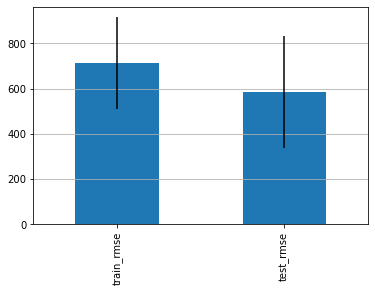

In [16]:
conf_intervals = scores_df.std() * 1.96
scores_df.mean().plot.bar(yerr=conf_intervals)
plt.grid(axis='y')

# Future Work

### Improving the model

The performance of the model could be improved by taking the search and optimization further, for the other regression algorithms as well.

In terms of extra features, there aren't many that could be added based on this dataset. For example, there is not enough information to identify holidays. The transformation of the Post hour feature into a x, y vector space did not improve the performance. We could try cutting the date-related information into bins and observe if this would improve the model.

Another option is to identify individual pages based on the number of page likes, with a small probability of collisions, as there might be different pages with similar page likes. This could be studied in detail, and provide an extra important feature for building this model.

### Productionisation

##### Training

A potential workflow design is to evaluate and choose the algorithm (XGBoost etc.) periodically, e.g. monthly, and tune the selected algorithm in regular intervals, e.g. daily, weekly or monthly, based on new data.

##### Evaluation

Another important step is to evaluate the performance of the algorithm, e.g. against pre-configured thresholds, or historical performance values, and trigger changes (e.g. error messages, or retuning / retraining) if it is underperforming.

##### Tests - Error Handling

As the dataset is small and clean with no edge cases, we didn't add any error handling checks. We also didn't include any unit tests to capture errors. A production-ready solution would need to cover both, with proper handling of errors, leading to hard failure or fallback to default values, to avoid breaking the application that depends on it.

##### Deployment

The deployment of this model depends on its application, e.g. whether new data come in batches or in real time, and when the predictions need to be performed. As an example, it could be deployed in a Flask (or similar) web application, exposing an API endpoint for predictions.

### More advanced Exploratory Data Analysis

Exploratory Data Analysis is a really important part of a modeling procedure that may unlock value and further improve the modelling process.